# Session 3.2: Complete RAG Evaluation Suite

## Overview

In this notebook, we'll build a comprehensive evaluation framework for RAG systems:
- **Test Dataset Creation**: Questions with ground truth answers
- **Retrieval Metrics**: Precision@K, Recall@K, MRR
- **LLM-as-Judge**: Automated answer quality assessment
- **Configuration Comparison**: Systematic testing of different RAG setups
- **Summary Reports**: Actionable insights from evaluation

**Learning Objectives:**
- Understand why proper evaluation is critical
- Implement retrieval quality metrics
- Use LLM-as-judge for answer evaluation
- Compare RAG configurations systematically

**Key Insight:**
> Cosine similarity measures semantic structure, NOT factual correctness.  
> "Paris is the capital of France" and "Lyon is the capital of France" have ~0.95 similarity!

## Why Proper Evaluation Matters

### The Cosine Similarity Trap

```python
# These have HIGH cosine similarity:
correct = "Paris is the capital of France"      # ✓ Correct
wrong   = "Lyon is the capital of France"       # ✗ Wrong!

cosine_similarity(correct, wrong) ≈ 0.95  # Almost identical!
```

### Two Types of Evaluation

| Metric Type | What to Measure | Method |
|-------------|-----------------|--------|
| **Retrieval Quality** | Did we find the right documents? | Cosine similarity ✓ |
| **Answer Quality** | Is the answer factually correct? | LLM-as-Judge ✓ |

**Never use cosine similarity to evaluate answer correctness!**

## Section 1: Setup and Installation

In [1]:
# Install required packages
# Note: Qwen3 reranker requires transformers>=4.51.0
!pip install chromadb openai rank-bm25 sentence-transformers pandas matplotlib -q
!pip install transformers>=4.51.0 -q

print("✓ Packages installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.0 MB/s eta 

In [2]:
import chromadb
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple, Any, Set
from dataclasses import dataclass, asdict
from openai import OpenAI
from rank_bm25 import BM25Okapi
from sentence_transformers import CrossEncoder
import os
from datetime import datetime

print("✓ All imports successful")

✓ All imports successful


In [26]:
# Configure OpenRouter API
from google.colab import userdata
os.environ['OPENROUTER_API_KEY'] = userdata.get('OPENROUTER_API_KEY')

OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY', None)

if not OPENROUTER_API_KEY:
    raise ValueError("Please set your OpenRouter API key in Colab secrets.")

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY
)

EMBEDDING_MODEL = "openai/text-embedding-3-large"
LLM_MODEL = "google/gemini-3-flash-preview"
JUDGE_MODEL = "anthropic/claude-opus-4.5"  # Can use a stronger model for judging

print(f"✓ OpenRouter configured")
print(f"✓ Judge model: {JUDGE_MODEL}")

✓ OpenRouter configured
✓ Judge model: anthropic/claude-opus-4.5


## Section 2: Load Documents and Build RAG Systems

### Upload Instructions

Upload the same data files used in Notebook 05:
1. Click the **folder icon** (📁) in the left sidebar
2. Click the **upload icon** (⬆️) and select:
   - `tecaj.md` (Croatian)
   - `moodle.md` (English)

If you've already uploaded them in Notebook 05 and haven't restarted the runtime, they should still be in `/content/`.

In [8]:
# Upload files if not already present
from google.colab import files
import os

tecaj_path = '/content/tecaj.md'
moodle_path = '/content/moodle.md'

files_needed = []
if not os.path.exists(tecaj_path):
    files_needed.append('tecaj.md')
if not os.path.exists(moodle_path):
    files_needed.append('moodle.md')

if files_needed:
    print(f"Please upload: {', '.join(files_needed)}")
    uploaded = files.upload()
    for filename in uploaded.keys():
        target = tecaj_path if filename == 'tecaj.md' else moodle_path
        with open(target, 'wb') as f:
            f.write(uploaded[filename])
    print("✓ Files uploaded!")
else:
    print("✓ Files already present")

# Load documents
with open(tecaj_path, 'r', encoding='utf-8') as f:
    TECAJ_CONTENT = f.read()
with open(moodle_path, 'r', encoding='utf-8') as f:
    MOODLE_CONTENT = f.read()

print(f"✓ tecaj.md: {len(TECAJ_CONTENT):,} chars")
print(f"✓ moodle.md: {len(MOODLE_CONTENT):,} chars")

✓ Files already present
✓ tecaj.md: 235,490 chars
✓ moodle.md: 114,342 chars


In [9]:
# Simple word-based chunking with overlap
def chunk_text(text: str, chunk_size: int = 300, overlap: int = 50, source_prefix: str = "") -> List[Dict]:
    """Chunk text by word count with overlap."""
    words = text.split()
    chunks = []
    chunk_id = 0

    for i in range(0, len(words), chunk_size - overlap):
        chunk_words = words[i:i + chunk_size]
        chunk_str = ' '.join(chunk_words)

        if len(chunk_words) >= 20:
            chunks.append({
                'text': chunk_str,
                'chunk_id': f'{source_prefix}chunk_{chunk_id}',
                'word_count': len(chunk_words)
            })
            chunk_id += 1
    return chunks

# Process with unique prefixes
tecaj_chunks = chunk_text(TECAJ_CONTENT, source_prefix="tecaj_")
moodle_chunks = chunk_text(MOODLE_CONTENT, source_prefix="moodle_")

for chunk in tecaj_chunks:
    chunk['source'] = 'tecaj.md'
    chunk['language'] = 'hr'

for chunk in moodle_chunks:
    chunk['source'] = 'moodle.md'
    chunk['language'] = 'en'

all_chunks = tecaj_chunks + moodle_chunks

print(f"✓ {len(all_chunks)} chunks ({len(tecaj_chunks)} Croatian, {len(moodle_chunks)} English)")

✓ 197 chunks (134 Croatian, 63 English)


In [10]:
# Build ChromaDB collection
class OpenRouterEmbeddingFunction:
    """Custom embedding function with embed_query support for ChromaDB."""
    def __init__(self, api_key: str, model: str = EMBEDDING_MODEL):
        self.client = OpenAI(base_url="https://openrouter.ai/api/v1", api_key=api_key)
        self.model = model

    def __call__(self, input: List[str]) -> List[List[float]]:
        response = self.client.embeddings.create(input=input, model=self.model)
        return [item.embedding for item in response.data]

    def embed_query(self, input: List[str]) -> List[List[float]]:
        """Required by ChromaDB for query embedding."""
        return self.__call__(input)

embedding_function = OpenRouterEmbeddingFunction(OPENROUTER_API_KEY)
chroma_client = chromadb.Client()

try:
    chroma_client.delete_collection(name="eval_docs")
except:
    pass

collection = chroma_client.create_collection(
    name="eval_docs",
    embedding_function=embedding_function,
    metadata={"hnsw:space": "cosine"}
)

collection.add(
    documents=[c['text'] for c in all_chunks],
    ids=[c['chunk_id'] for c in all_chunks],
    metadatas=[{'source': c['source'], 'language': c['language']} for c in all_chunks]
)

print(f"✓ Indexed {collection.count()} chunks")

✓ Indexed 197 chunks


In [11]:
# BM25 and Hybrid Search (reused from Notebook 05)
class BM25Retriever:
    def __init__(self, chunks: List[Dict]):
        self.chunks = chunks
        self.tokenized = [self._tokenize(c['text']) for c in chunks]
        self.bm25 = BM25Okapi(self.tokenized)

    def _tokenize(self, text: str) -> List[str]:
        return re.sub(r'[^\w\s]', ' ', text.lower()).split()

    def search(self, query: str, top_k: int = 10) -> List[Dict]:
        scores = self.bm25.get_scores(self._tokenize(query))
        top_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
        return [{'chunk_id': self.chunks[i]['chunk_id'], 'text': self.chunks[i]['text'],
                 'metadata': {'source': self.chunks[i]['source']}, 'bm25_score': float(scores[i])}
                for i in top_idx]

def semantic_search(query: str, collection, top_k: int = 5) -> List[Dict]:
    results = collection.query(query_texts=[query], n_results=top_k)
    return [{'chunk_id': results['ids'][0][i], 'text': results['documents'][0][i],
             'metadata': results['metadatas'][0][i], 'similarity': 1 - results['distances'][0][i]}
            for i in range(len(results['documents'][0]))]

def reciprocal_rank_fusion(rankings: List[List[Dict]], k: int = 60) -> List[Dict]:
    rrf_scores, chunk_data = {}, {}
    for ranking in rankings:
        for rank, item in enumerate(ranking, 1):
            cid = item['chunk_id']
            chunk_data.setdefault(cid, item)
            rrf_scores[cid] = rrf_scores.get(cid, 0) + 1.0 / (k + rank)
    return [{**chunk_data[cid], 'rrf_score': rrf_scores[cid]}
            for cid in sorted(rrf_scores, key=rrf_scores.get, reverse=True)]

class HybridRetriever:
    def __init__(self, bm25: BM25Retriever, collection):
        self.bm25, self.collection = bm25, collection

    def search(self, query: str, top_k: int = 10, n_candidates: int = 30) -> List[Dict]:
        bm25_res = self.bm25.search(query, top_k=n_candidates)
        sem_res = semantic_search(query, self.collection, top_k=n_candidates)
        return reciprocal_rank_fusion([bm25_res, sem_res])[:top_k]

bm25_retriever = BM25Retriever(all_chunks)
hybrid_retriever = HybridRetriever(bm25_retriever, collection)
print("✓ Retrievers ready")

✓ Retrievers ready


In [12]:
# Qwen3 cross-encoder reranker (multilingual, supports Croatian)
RERANKER_MODEL = "tomaarsen/Qwen3-Reranker-0.6B-seq-cls"
# Alternative: "dengcao/Qwen3-Reranker-4B-seq-cls" (better quality, more VRAM)

print(f"Loading Qwen3 reranker: {RERANKER_MODEL}...")
reranker_model = CrossEncoder(RERANKER_MODEL, trust_remote_code=True)

def format_query_for_qwen3(query: str, instruction: str = None) -> str:
    """Format query with Qwen3 reranker prompt template."""
    prefix = '<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be "yes" or "no".<|im_end|>\n<|im_start|>user\n'
    if instruction is None:
        instruction = "Given a web search query, retrieve relevant passages that answer the query"
    return f"{prefix}<Instruct>: {instruction}\n<Query>: {query}\n"

def format_document_for_qwen3(document: str) -> str:
    """Format document with Qwen3 reranker prompt template."""
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    return f"<Document>: {document}{suffix}"

def rerank(query: str, candidates: List[Dict], top_k: int = 5) -> List[Dict]:
    """Rerank candidates using Qwen3 cross-encoder."""
    if not candidates:
        return []

    # Format pairs with Qwen3 template
    formatted_query = format_query_for_qwen3(query)
    pairs = [
        [formatted_query, format_document_for_qwen3(c['text'])]
        for c in candidates
    ]

    scores = reranker_model.predict(pairs)
    for i, c in enumerate(candidates):
        c['rerank_score'] = float(scores[i])
    return sorted(candidates, key=lambda x: x['rerank_score'], reverse=True)[:top_k]

print("✓ Qwen3 reranker ready (multilingual, 100+ languages)")

Loading Qwen3 reranker: tomaarsen/Qwen3-Reranker-0.6B-seq-cls...


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.38G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

✓ Qwen3 reranker ready (multilingual, 100+ languages)


## Section 3: Test Dataset Creation

A good test dataset should have:
- **Questions**: Clear, specific questions
- **Expected Answers**: Ground truth for evaluation
- **Relevant Chunks**: Which chunks contain the answer (for retrieval evaluation)
- **Difficulty Levels**: Easy, Medium, Hard
- **Topics**: Categorization for analysis

In [13]:
@dataclass
class TestCase:
    """A single test case for evaluation."""
    question: str
    expected_answer: str
    relevant_keywords: List[str]  # Keywords that should appear in relevant chunks
    difficulty: str  # easy, medium, hard
    topic: str
    language: str  # hr, en


# Croatian test questions (from tecaj.md)
TECAJ_TEST_CASES = [
    TestCase(
        question="Kako nastavnik može promijeniti nazive uloga u tečaju, na primjer preimenovati 'Student' u 'Učenik'?",
        expected_answer="Unutar postavki tečaja, u dijelu 'Preimenovanje uloga' nastavnik može preimenovati uloge te im dodijeliti nove nazive. Na primjer, ulogu Nastavnika može preimenovati u Predavača, a Studenta u Učenika. Mijenjanjem naziva uloga ne mijenjaju se njihove ovlasti u tečaju.",
        relevant_keywords=["preimenovanje", "uloga", "student", "učenik"],
        difficulty="medium",
        topic="roles",
        language="hr"
    ),
    TestCase(
        question="Što se događa ako nastavnik postavi 'Zahtijevaj od studenata klik na gumb za predavanje zadaće' na DA?",
        expected_answer="Ako nastavnik odabere DA, polaznici će moći učitati zadaću kao nacrt, a tek nakon toga dodatno potvrditi njeno slanje na ocjenjivanje. Dok je u fazi nacrta, polaznik može zadaću izbrisati te ponovno učitati, sve do konačne potvrde slanja.",
        relevant_keywords=["zahtijevaj", "klik", "gumb", "nacrt", "zadaća"],
        difficulty="hard",
        topic="assignments",
        language="hr"
    ),
    TestCase(
        question="Koja je razlika između središnjeg i sekundarnog rječnika u Moodleu?",
        expected_answer="U tečaju može postojati samo jedan središnji rječnik koji može uređivati samo predavač. Sekundarnih rječnika može biti neograničen broj i oni dopuštaju unose i komentare polaznika.",
        relevant_keywords=["središnji", "sekundarni", "rječnik"],
        difficulty="medium",
        topic="glossary",
        language="hr"
    ),
    TestCase(
        question="Kako funkcionira opcija 'Ocjenjivanje naslijepo' kod zadaća?",
        expected_answer="Ako kod opcije 'Ocjenjivanje naslijepo' odaberete DA, sustav će umjesto imena i prezimena polaznika prilikom ocjenjivanja zadaće prikazati naziv Sudionik 1, Sudionik 2 i tako redom, što omogućuje anonimno ocjenjivanje.",
        relevant_keywords=["ocjenjivanje", "naslijepo", "sudionik", "anonimno"],
        difficulty="easy",
        topic="assignments",
        language="hr"
    ),
    TestCase(
        question="Kako podesiti da svaki polaznik u testu dobije pitanja i odgovore u različitom redoslijedu?",
        expected_answer="U dijelu 'Karakteristika pitanja' možete odabrati da se osim redoslijeda pitanja izmiješa i redoslijed odgovora unutar pitanja. Ako odaberete da odgovori budu izmješana slučajnim rasporedom, oni će kod svakog polaznika biti drugačije raspoređeni.",
        relevant_keywords=["karakteristika", "pitanja", "izmješan", "redoslijed"],
        difficulty="medium",
        topic="quiz",
        language="hr"
    ),
    TestCase(
        question="Koliko vremena su demo tečajevi dostupni nakon završetka i što trebam napraviti ako želim nastaviti koristiti svoj tečaj?",
        expected_answer="Demo tečajevi dostupni su 2 mjeseca nakon službenog završetka tečaja. Ako tečaj želite koristiti i nakon ovog roka, napravite sigurnosnu kopiju tečaja i prebacite ga u Moodle sustav koji vam je dostupan. CARNetovi korisnici s AAI@Edu.hr identitetom mogu obnoviti kopiju na sustav loomen.carnet.hr.",
        relevant_keywords=["demo", "2 mjeseca", "sigurnosna kopija", "loomen.carnet.hr"],
        difficulty="hard",
        topic="course_management",
        language="hr"
    )
]

# English test questions (from moodle.md)
MOODLE_TEST_CASES = [
    TestCase(
        question="What is the difference between Authentication and Enrolment in Moodle?",
        expected_answer="Authentication is the process of adding users to a Moodle site (creating accounts), while Enrolment is the process of adding students to specific courses. Users must first be authenticated on the site before they can be enrolled in courses.",
        relevant_keywords=["authentication", "enrolment", "accounts", "courses"],
        difficulty="easy",
        topic="users",
        language="en"
    ),
    TestCase(
        question="What are the five phases of a Workshop activity?",
        expected_answer="The five phases are: 1) Setup phase - teacher configures the workshop, 2) Submission phase - students submit work, 3) Assessment phase - students assess peers' work, 4) Grading evaluation phase - Moodle calculates final grades, 5) Closed phase - students see grades and published submissions.",
        relevant_keywords=["workshop", "phase", "setup", "submission", "assessment"],
        difficulty="hard",
        topic="workshop",
        language="en"
    ),
    TestCase(
        question="How can a teacher restrict when students can see certain course content?",
        expected_answer="Teachers can manually hide items using the 'hide' icon when editing is on. If Restrict access is enabled, a Restrict access section appears in activity settings allowing teachers to set conditions based on date, grade, group membership, or activity completion.",
        relevant_keywords=["restrict", "access", "hide", "conditions"],
        difficulty="medium",
        topic="access_control",
        language="en"
    ),
    TestCase(
        question="What is the difference between creating an alias and a copy when reusing a file in Moodle?",
        expected_answer="When creating an alias/link, the file is connected to the original - updates to the original automatically update all aliases. When creating a copy, a new independent version is created that won't be affected by changes to the original file.",
        relevant_keywords=["alias", "copy", "link", "original", "independent"],
        difficulty="medium",
        topic="files",
        language="en"
    ),
    TestCase(
        question="How do students receive two grades in a Workshop activity?",
        expected_answer="Students receive one grade for the work they submit (submission grade) and one grade for the quality of their peer assessments (assessment grade). The assessment grade reflects how well their ratings aligned with other students' ratings or the teacher's expected ratings.",
        relevant_keywords=["workshop", "two grades", "submission", "assessment"],
        difficulty="medium",
        topic="workshop",
        language="en"
    ),
    TestCase(
        question="What are the steps to delete multiple courses at once in Moodle?",
        expected_answer="To delete multiple courses: 1) Create a temporary category like 'To be deleted', 2) Move the courses to that category, 3) Delete the category itself choosing 'Delete ALL - cannot be undone'. This deletes all courses in that category.",
        relevant_keywords=["delete", "multiple", "courses", "category"],
        difficulty="medium",
        topic="course_management",
        language="en"
    )
]

# Combine all test cases
ALL_TEST_CASES = TECAJ_TEST_CASES + MOODLE_TEST_CASES

print(f"✓ Created {len(ALL_TEST_CASES)} test cases")
print(f"  - Croatian: {len(TECAJ_TEST_CASES)}")
print(f"  - English: {len(MOODLE_TEST_CASES)}")

# Show distribution
difficulties = [tc.difficulty for tc in ALL_TEST_CASES]
print(f"\nDifficulty distribution:")
for d in ['easy', 'medium', 'hard']:
    print(f"  {d}: {difficulties.count(d)}")

✓ Created 12 test cases
  - Croatian: 6
  - English: 6

Difficulty distribution:
  easy: 2
  medium: 7
  hard: 3


## Section 4: Retrieval Quality Metrics

### Metrics Explained

**Precision@K**: Of the K documents retrieved, how many are relevant?
```
P@K = (relevant ∩ retrieved@K) / K
```

**Recall@K**: Of all relevant documents, how many did we retrieve in top-K?
```
R@K = (relevant ∩ retrieved@K) / |relevant|
```

**MRR (Mean Reciprocal Rank)**: Where does the first relevant document appear?
```
MRR = 1 / rank_of_first_relevant
```

In [14]:
def is_chunk_relevant(chunk_text: str, keywords: List[str]) -> bool:
    """
    Check if a chunk is relevant based on keyword presence.
    A chunk is relevant if it contains at least half of the keywords.
    """
    chunk_lower = chunk_text.lower()
    matches = sum(1 for kw in keywords if kw.lower() in chunk_lower)
    return matches >= len(keywords) / 2


def precision_at_k(retrieved: List[Dict], keywords: List[str], k: int) -> float:
    """
    Calculate Precision@K.
    """
    if k == 0:
        return 0.0

    relevant_count = sum(
        1 for r in retrieved[:k]
        if is_chunk_relevant(r['text'], keywords)
    )
    return relevant_count / k


def recall_at_k(retrieved: List[Dict], keywords: List[str], k: int,
                all_chunks: List[Dict]) -> float:
    """
    Calculate Recall@K.
    """
    # Find all relevant chunks
    all_relevant = [c for c in all_chunks if is_chunk_relevant(c['text'], keywords)]

    if len(all_relevant) == 0:
        return 0.0

    # Count relevant in retrieved
    retrieved_ids = {r['chunk_id'] for r in retrieved[:k]}
    relevant_retrieved = sum(
        1 for c in all_relevant
        if c['chunk_id'] in retrieved_ids
    )

    return relevant_retrieved / len(all_relevant)


def mean_reciprocal_rank(retrieved: List[Dict], keywords: List[str]) -> float:
    """
    Calculate Mean Reciprocal Rank.
    """
    for rank, r in enumerate(retrieved, 1):
        if is_chunk_relevant(r['text'], keywords):
            return 1.0 / rank
    return 0.0


print("✓ Retrieval metric functions defined")

✓ Retrieval metric functions defined


In [16]:
def evaluate_retrieval(
    test_cases: List[TestCase],
    retriever,
    all_chunks: List[Dict],
    k_values: List[int] = [1, 3, 5, 10],
    use_reranking: bool = False
) -> Dict[str, float]:
    """
    Evaluate retrieval on all test cases.
    """
    metrics = {f'P@{k}': [] for k in k_values}
    metrics.update({f'R@{k}': [] for k in k_values})
    metrics['MRR'] = []

    for tc in test_cases:
        # Get retrieval results
        # Check for custom retrievers (BM25Retriever, HybridRetriever) vs ChromaDB collection
        if isinstance(retriever, (BM25Retriever, HybridRetriever)):
            retrieved = retriever.search(tc.question, top_k=max(k_values))
        else:
            retrieved = semantic_search(tc.question, retriever, top_k=max(k_values))

        # Optional reranking
        if use_reranking:
            retrieved = rerank(tc.question, retrieved, top_k=max(k_values))

        # Calculate metrics
        for k in k_values:
            metrics[f'P@{k}'].append(precision_at_k(retrieved, tc.relevant_keywords, k))
            metrics[f'R@{k}'].append(recall_at_k(retrieved, tc.relevant_keywords, k, all_chunks))

        metrics['MRR'].append(mean_reciprocal_rank(retrieved, tc.relevant_keywords))

    # Average all metrics
    return {k: np.mean(v) for k, v in metrics.items()}


# Evaluate different retrieval methods
print("Evaluating retrieval methods...\n")

# Semantic only
semantic_metrics = evaluate_retrieval(ALL_TEST_CASES, collection, all_chunks)
print("SEMANTIC SEARCH:")
for k, v in semantic_metrics.items():
    print(f"  {k}: {v:.3f}")

# Hybrid
print("\nHYBRID SEARCH:")
hybrid_metrics = evaluate_retrieval(ALL_TEST_CASES, hybrid_retriever, all_chunks)
for k, v in hybrid_metrics.items():
    print(f"  {k}: {v:.3f}")

# Hybrid + Reranking
print("\nHYBRID + RERANKING:")
rerank_metrics = evaluate_retrieval(ALL_TEST_CASES, hybrid_retriever, all_chunks, use_reranking=True)
for k, v in rerank_metrics.items():
    print(f"  {k}: {v:.3f}")

Evaluating retrieval methods...

SEMANTIC SEARCH:
  P@1: 0.917
  P@3: 0.861
  P@5: 0.750
  P@10: 0.508
  R@1: 0.164
  R@3: 0.443
  R@5: 0.588
  R@10: 0.737
  MRR: 0.944

HYBRID SEARCH:
  P@1: 1.000
  P@3: 0.889
  P@5: 0.733
  P@10: 0.508
  R@1: 0.176
  R@3: 0.453
  R@5: 0.579
  R@10: 0.744
  MRR: 1.000

HYBRID + RERANKING:
  P@1: 1.000
  P@3: 0.917
  P@5: 0.833
  P@10: 0.508
  R@1: 0.176
  R@3: 0.468
  R@5: 0.650
  R@10: 0.744
  MRR: 1.000


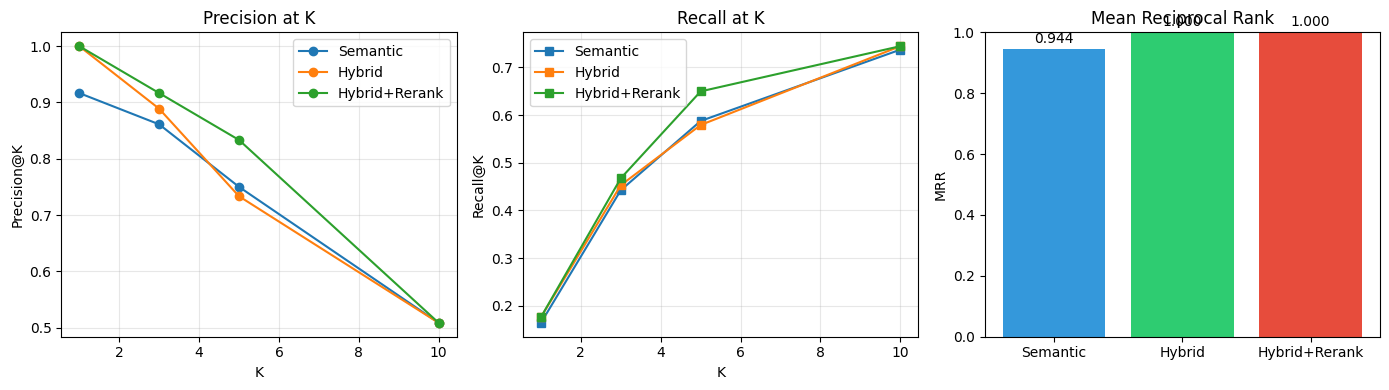

In [17]:
# Visualize retrieval metrics
methods = ['Semantic', 'Hybrid', 'Hybrid+Rerank']
all_metrics = [semantic_metrics, hybrid_metrics, rerank_metrics]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# P@K
ax1 = axes[0]
k_values = [1, 3, 5, 10]
for i, (method, metrics) in enumerate(zip(methods, all_metrics)):
    p_values = [metrics[f'P@{k}'] for k in k_values]
    ax1.plot(k_values, p_values, marker='o', label=method)
ax1.set_xlabel('K')
ax1.set_ylabel('Precision@K')
ax1.set_title('Precision at K')
ax1.legend()
ax1.grid(True, alpha=0.3)

# R@K
ax2 = axes[1]
for i, (method, metrics) in enumerate(zip(methods, all_metrics)):
    r_values = [metrics[f'R@{k}'] for k in k_values]
    ax2.plot(k_values, r_values, marker='s', label=method)
ax2.set_xlabel('K')
ax2.set_ylabel('Recall@K')
ax2.set_title('Recall at K')
ax2.legend()
ax2.grid(True, alpha=0.3)

# MRR
ax3 = axes[2]
mrr_values = [m['MRR'] for m in all_metrics]
bars = ax3.bar(methods, mrr_values, color=['#3498db', '#2ecc71', '#e74c3c'])
ax3.set_ylabel('MRR')
ax3.set_title('Mean Reciprocal Rank')
ax3.set_ylim(0, 1)
for bar, val in zip(bars, mrr_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Section 5: LLM-as-Judge Evaluation

### Why LLM-as-Judge?

- **Cosine similarity fails** for answer evaluation (semantic ≠ factual)
- **Human evaluation** is expensive and slow
- **LLM judges** can assess multiple dimensions of quality

### Evaluation Criteria

1. **Factual Accuracy** (0-10): Are the facts correct?
2. **Completeness** (0-10): Are all key points covered?
3. **Relevance** (0-10): Does it answer the question?
4. **Clarity** (0-10): Is it well-organized and clear?
5. **Grounding** (0-10): Is it based on context (no hallucinations)?

In [24]:
JUDGE_PROMPT = """You are an expert evaluator assessing the quality of an AI assistant's answer.

## Context from retrieved documents:
{context}

## Question:
{question}

## Expected/Reference Answer:
{reference_answer}

## AI Assistant's Answer:
{model_answer}

## Evaluation Criteria (score 0-10 for each):

1. **FACTUAL_ACCURACY**: Are all facts correct based on the context?
2. **COMPLETENESS**: Does it cover all key points from the reference?
3. **RELEVANCE**: Does it directly answer the question?
4. **CLARITY**: Is it well-organized and easy to understand?
5. **GROUNDING**: Is it derived from context without hallucinations?

Respond with ONLY valid JSON, no other text:
{{"scores": {{"factual_accuracy": <0-10>, "completeness": <0-10>, "relevance": <0-10>, "clarity": <0-10>, "grounding": <0-10>}}, "overall": <0-10>, "verdict": "<CORRECT|PARTIALLY_CORRECT|INCORRECT>", "reasoning": "<brief explanation>"}}
"""


@dataclass
class JudgmentResult:
    """Result from LLM-as-judge evaluation."""
    question: str
    model_answer: str
    reference_answer: str
    scores: Dict[str, float]
    overall: float
    verdict: str
    reasoning: str
    difficulty: str
    topic: str


def judge_answer(
    question: str,
    model_answer: str,
    reference_answer: str,
    context: str
) -> Dict[str, Any]:
    """
    Use LLM to judge answer quality.
    """
    prompt = JUDGE_PROMPT.format(
        context=context,
        question=question,
        reference_answer=reference_answer,
        model_answer=model_answer
    )

    response = client.chat.completions.create(
        model=JUDGE_MODEL,
        messages=[
            {"role": "system", "content": "You are a JSON-only evaluator. Respond with valid JSON only, no markdown."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2,
        max_tokens=1000
    )

    text = response.choices[0].message.content.strip()

    # Parse JSON from response
    try:
        # Remove markdown code blocks if present
        if text.startswith("```"):
            text = text.split("```")[1]
            if text.startswith("json"):
                text = text[4:]
            text = text.strip()

        return json.loads(text)
    except Exception as e:
        # Debug: print the raw response to see what's happening
        print(f"\n  [DEBUG] Failed to parse response. Raw text:\n{text[:500]}")
        print(f"  [DEBUG] Error: {e}\n")
        return {
            "scores": {"factual_accuracy": 0, "completeness": 0, "relevance": 0, "clarity": 0, "grounding": 0},
            "overall": 0,
            "verdict": "ERROR",
            "reasoning": f"Failed to parse judge response: {str(e)}"
        }


print("✓ Judge functions defined")

✓ Judge functions defined


In [22]:
def generate_rag_answer(question: str, top_k: int = 3) -> Tuple[str, str]:
    """
    Generate RAG answer and return (answer, context).
    """
    # Retrieve
    candidates = hybrid_retriever.search(question, top_k=15)
    results = rerank(question, candidates, top_k=top_k)

    # Build context
    context = "\n\n".join([f"[{i+1}]: {r['text']}" for i, r in enumerate(results)])

    # Generate
    prompt = f"""Answer the question based on the following context. Be concise and accurate.

Context:
{context}

Question: {question}

Answer:"""

    response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=500
    )

    return response.choices[0].message.content, context


# Test on a few examples
print("Testing RAG answer generation...\n")

test_q = ALL_TEST_CASES[0]
answer, context = generate_rag_answer(test_q.question)

print(f"Question: {test_q.question}")
print(f"\nGenerated Answer:\n{answer}")

Testing RAG answer generation...

Question: Kako nastavnik može promijeniti nazive uloga u tečaju, na primjer preimenovati 'Student' u 'Učenik'?

Generated Answer:
Nastavnik može promijeniti nazive uloga unutar postavki tečaja, u dijelu **Preimenovanje uloga**. Tamo može dodijeliti nove nazive (npr. ulogu Studenta preimenovati u Učenika), pri čemu se ovlasti uloge ne mijenjaju.


In [27]:
def run_full_evaluation(
    test_cases: List[TestCase],
    max_cases: int = None
) -> List[JudgmentResult]:
    """
    Run full evaluation on test cases.
    """
    cases = test_cases[:max_cases] if max_cases else test_cases
    results = []

    for i, tc in enumerate(cases):
        print(f"\nEvaluating {i+1}/{len(cases)}: {tc.question[:50]}...")

        # Generate RAG answer
        model_answer, context = generate_rag_answer(tc.question)

        # Judge the answer
        judgment = judge_answer(
            question=tc.question,
            model_answer=model_answer,
            reference_answer=tc.expected_answer,
            context=context
        )

        result = JudgmentResult(
            question=tc.question,
            model_answer=model_answer,
            reference_answer=tc.expected_answer,
            scores=judgment.get('scores', {}),
            overall=judgment.get('overall', 0),
            verdict=judgment.get('verdict', 'ERROR'),
            reasoning=judgment.get('reasoning', ''),
            difficulty=tc.difficulty,
            topic=tc.topic
        )
        results.append(result)

        print(f"  Verdict: {result.verdict} | Overall: {result.overall}/10")

    return results


# Run evaluation (limit to save API costs)
print("Running full evaluation...")
evaluation_results = run_full_evaluation(ALL_TEST_CASES, max_cases=6)  # Adjust as needed

Running full evaluation...

Evaluating 1/6: Kako nastavnik može promijeniti nazive uloga u teč...
  Verdict: CORRECT | Overall: 9/10

Evaluating 2/6: Što se događa ako nastavnik postavi 'Zahtijevaj od...
  Verdict: CORRECT | Overall: 10/10

Evaluating 3/6: Koja je razlika između središnjeg i sekundarnog rj...
  Verdict: CORRECT | Overall: 10/10

Evaluating 4/6: Kako funkcionira opcija 'Ocjenjivanje naslijepo' k...
  Verdict: CORRECT | Overall: 9/10

Evaluating 5/6: Kako podesiti da svaki polaznik u testu dobije pit...
  Verdict: PARTIALLY_CORRECT | Overall: 8/10

Evaluating 6/6: Koliko vremena su demo tečajevi dostupni nakon zav...
  Verdict: CORRECT | Overall: 9/10


In [28]:
# Analyze results
def analyze_results(results: List[JudgmentResult]) -> None:
    """
    Analyze and visualize evaluation results.
    """
    if not results:
        print("No results to analyze")
        return

    # Overall statistics
    overall_scores = [r.overall for r in results]
    verdicts = [r.verdict for r in results]

    print("\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)
    print(f"\nTotal test cases: {len(results)}")
    print(f"Average score: {np.mean(overall_scores):.2f}/10")
    print(f"\nVerdict distribution:")
    for v in ['CORRECT', 'PARTIALLY_CORRECT', 'INCORRECT', 'ERROR']:
        count = verdicts.count(v)
        if count > 0:
            print(f"  {v}: {count} ({count/len(results)*100:.1f}%)")

    # Score breakdown
    print(f"\nScore breakdown (average):")
    score_keys = ['factual_accuracy', 'completeness', 'relevance', 'clarity', 'grounding']
    for key in score_keys:
        scores = [r.scores.get(key, 0) for r in results]
        print(f"  {key}: {np.mean(scores):.2f}/10")

    # By difficulty
    print(f"\nBy difficulty:")
    for diff in ['easy', 'medium', 'hard']:
        diff_results = [r for r in results if r.difficulty == diff]
        if diff_results:
            avg = np.mean([r.overall for r in diff_results])
            print(f"  {diff}: {avg:.2f}/10 (n={len(diff_results)})")


analyze_results(evaluation_results)


EVALUATION SUMMARY

Total test cases: 6
Average score: 9.17/10

Verdict distribution:
  CORRECT: 5 (83.3%)
  PARTIALLY_CORRECT: 1 (16.7%)

Score breakdown (average):
  factual_accuracy: 9.67/10
  completeness: 8.67/10
  relevance: 10.00/10
  clarity: 9.83/10
  grounding: 9.50/10

By difficulty:
  easy: 9.00/10 (n=1)
  medium: 9.00/10 (n=3)
  hard: 9.50/10 (n=2)


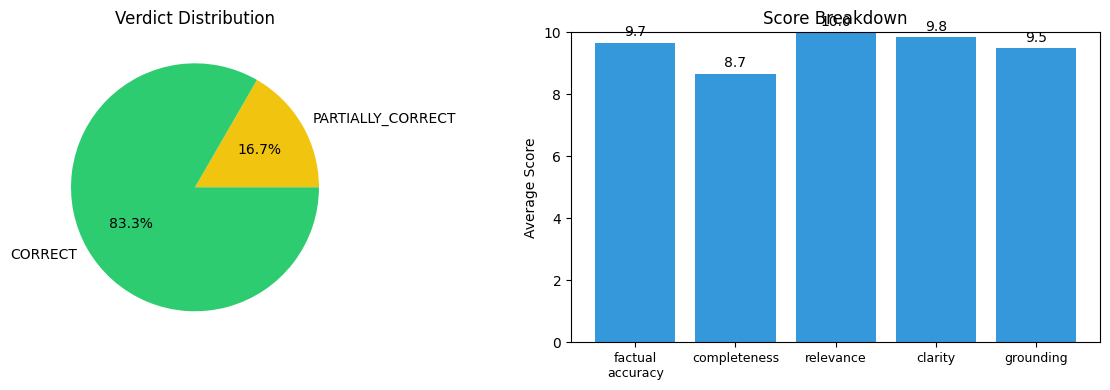

In [29]:
# Visualize results
if evaluation_results:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Verdict pie chart
    ax1 = axes[0]
    verdicts = [r.verdict for r in evaluation_results]
    verdict_counts = {v: verdicts.count(v) for v in set(verdicts)}
    colors = {'CORRECT': '#2ecc71', 'PARTIALLY_CORRECT': '#f1c40f', 'INCORRECT': '#e74c3c', 'ERROR': '#95a5a6'}
    ax1.pie(
        verdict_counts.values(),
        labels=verdict_counts.keys(),
        colors=[colors.get(v, '#95a5a6') for v in verdict_counts.keys()],
        autopct='%1.1f%%'
    )
    ax1.set_title('Verdict Distribution')

    # Score breakdown bar chart
    ax2 = axes[1]
    score_keys = ['factual_accuracy', 'completeness', 'relevance', 'clarity', 'grounding']
    avg_scores = [np.mean([r.scores.get(k, 0) for r in evaluation_results]) for k in score_keys]
    bars = ax2.bar(range(len(score_keys)), avg_scores, color='#3498db')
    ax2.set_xticks(range(len(score_keys)))
    ax2.set_xticklabels([k.replace('_', '\n') for k in score_keys], fontsize=9)
    ax2.set_ylabel('Average Score')
    ax2.set_ylim(0, 10)
    ax2.set_title('Score Breakdown')
    for bar, val in zip(bars, avg_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                 f'{val:.1f}', ha='center')

    plt.tight_layout()
    plt.show()

## Section 6: Configuration Comparison

Let's compare different RAG configurations systematically.

In [30]:
@dataclass
class RAGConfig:
    """Configuration for RAG evaluation."""
    name: str
    use_hybrid: bool = True
    use_reranking: bool = True
    top_k_retrieve: int = 15
    top_k_final: int = 3


CONFIGURATIONS = [
    RAGConfig(name="Baseline (Semantic)", use_hybrid=False, use_reranking=False),
    RAGConfig(name="Hybrid Only", use_hybrid=True, use_reranking=False),
    RAGConfig(name="Semantic + Rerank", use_hybrid=False, use_reranking=True),
    RAGConfig(name="Full Enhanced", use_hybrid=True, use_reranking=True),
]


def generate_answer_with_config(question: str, config: RAGConfig) -> Tuple[str, str]:
    """
    Generate answer using specified configuration.
    """
    # Retrieve
    if config.use_hybrid:
        candidates = hybrid_retriever.search(question, top_k=config.top_k_retrieve)
    else:
        candidates = semantic_search(question, collection, top_k=config.top_k_retrieve)

    # Rerank
    if config.use_reranking:
        results = rerank(question, candidates, top_k=config.top_k_final)
    else:
        results = candidates[:config.top_k_final]

    # Build context
    context = "\n\n".join([f"[{i+1}]: {r['text']}" for i, r in enumerate(results)])

    # Generate
    prompt = f"""Answer the question based on the following context. Be concise and accurate.

Context:
{context}

Question: {question}

Answer:"""

    response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=500
    )

    return response.choices[0].message.content, context


print(f"✓ {len(CONFIGURATIONS)} configurations defined")

✓ 4 configurations defined


In [31]:
def compare_configurations(
    test_cases: List[TestCase],
    configs: List[RAGConfig],
    max_cases: int = 4
) -> Dict[str, Dict]:
    """
    Compare multiple RAG configurations.
    """
    comparison_results = {}
    cases = test_cases[:max_cases]

    for config in configs:
        print(f"\n{'='*60}")
        print(f"Testing: {config.name}")
        print(f"{'='*60}")

        config_scores = []
        config_verdicts = []

        for i, tc in enumerate(cases):
            print(f"  [{i+1}/{len(cases)}] {tc.question[:40]}...")

            # Generate answer
            answer, context = generate_answer_with_config(tc.question, config)

            # Judge
            judgment = judge_answer(
                question=tc.question,
                model_answer=answer,
                reference_answer=tc.expected_answer,
                context=context
            )

            config_scores.append(judgment.get('overall', 0))
            config_verdicts.append(judgment.get('verdict', 'ERROR'))

            print(f"    → {judgment.get('verdict', 'ERROR')} ({judgment.get('overall', 0)}/10)")

        comparison_results[config.name] = {
            'config': config,
            'avg_score': np.mean(config_scores),
            'scores': config_scores,
            'verdicts': config_verdicts,
            'correct_pct': config_verdicts.count('CORRECT') / len(config_verdicts) * 100
        }

    return comparison_results


# Run comparison (limited to save API costs)
print("Comparing configurations...")
comparison = compare_configurations(ALL_TEST_CASES, CONFIGURATIONS, max_cases=4)

Comparing configurations...

Testing: Baseline (Semantic)
  [1/4] Kako nastavnik može promijeniti nazive u...
    → CORRECT (9/10)
  [2/4] Što se događa ako nastavnik postavi 'Zah...
    → CORRECT (9/10)
  [3/4] Koja je razlika između središnjeg i seku...
    → CORRECT (10/10)
  [4/4] Kako funkcionira opcija 'Ocjenjivanje na...
    → CORRECT (9/10)

Testing: Hybrid Only
  [1/4] Kako nastavnik može promijeniti nazive u...
    → CORRECT (9/10)
  [2/4] Što se događa ako nastavnik postavi 'Zah...
    → CORRECT (9/10)
  [3/4] Koja je razlika između središnjeg i seku...
    → CORRECT (10/10)
  [4/4] Kako funkcionira opcija 'Ocjenjivanje na...
    → CORRECT (9/10)

Testing: Semantic + Rerank
  [1/4] Kako nastavnik može promijeniti nazive u...
    → CORRECT (9/10)
  [2/4] Što se događa ako nastavnik postavi 'Zah...
    → CORRECT (10/10)
  [3/4] Koja je razlika između središnjeg i seku...
    → CORRECT (10/10)
  [4/4] Kako funkcionira opcija 'Ocjenjivanje na...
    → CORRECT (9/10)

Testing: Fu

In [32]:
# Summary table
print("\n" + "="*70)
print("CONFIGURATION COMPARISON RESULTS")
print("="*70)

# Create summary DataFrame
summary_data = []
for name, data in comparison.items():
    summary_data.append({
        'Configuration': name,
        'Avg Score': f"{data['avg_score']:.2f}",
        'Correct %': f"{data['correct_pct']:.1f}%",
        'Hybrid': '✓' if data['config'].use_hybrid else '✗',
        'Rerank': '✓' if data['config'].use_reranking else '✗'
    })

df = pd.DataFrame(summary_data)
print(df.to_string(index=False))

# Rank by score
ranked = sorted(comparison.items(), key=lambda x: x[1]['avg_score'], reverse=True)
print(f"\n🏆 Best configuration: {ranked[0][0]} (Score: {ranked[0][1]['avg_score']:.2f}/10)")


CONFIGURATION COMPARISON RESULTS
      Configuration Avg Score Correct % Hybrid Rerank
Baseline (Semantic)      9.25    100.0%      ✗      ✗
        Hybrid Only      9.25    100.0%      ✓      ✗
  Semantic + Rerank      9.50    100.0%      ✗      ✓
      Full Enhanced      9.50    100.0%      ✓      ✓

🏆 Best configuration: Semantic + Rerank (Score: 9.50/10)


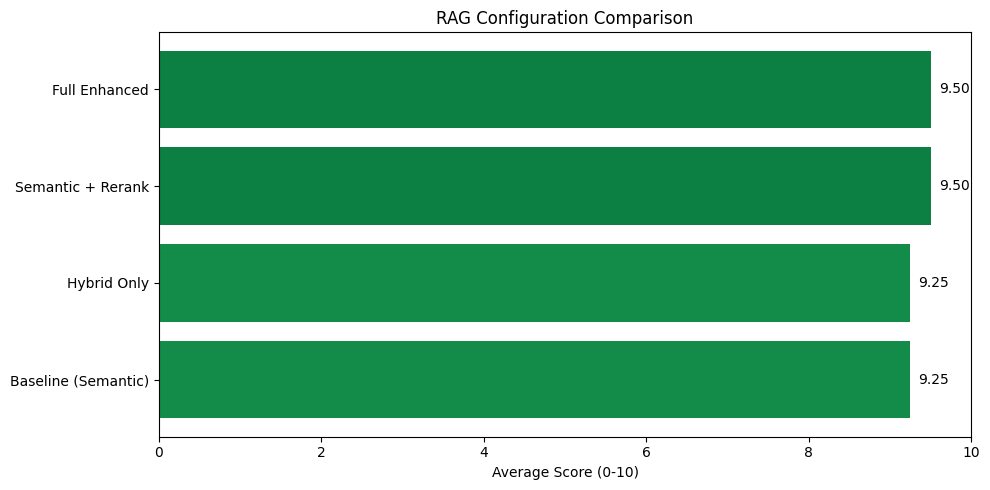

In [33]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 5))

names = list(comparison.keys())
scores = [comparison[n]['avg_score'] for n in names]

colors = plt.cm.RdYlGn(np.array(scores) / 10)  # Color by score
bars = ax.barh(names, scores, color=colors)

ax.set_xlabel('Average Score (0-10)')
ax.set_xlim(0, 10)
ax.set_title('RAG Configuration Comparison')

for bar, score in zip(bars, scores):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{score:.2f}', va='center')

plt.tight_layout()
plt.show()

## Section 7: Export Results and Summary Report

In [34]:
def generate_report(
    retrieval_metrics: Dict,
    evaluation_results: List[JudgmentResult],
    comparison: Dict
) -> str:
    """
    Generate a comprehensive evaluation report.
    """
    report = []
    report.append("="*70)
    report.append("RAG EVALUATION REPORT")
    report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("="*70)

    # Retrieval metrics
    report.append("\n## RETRIEVAL METRICS (Hybrid + Reranking)")
    report.append("-"*40)
    for k, v in retrieval_metrics.items():
        report.append(f"{k}: {v:.3f}")

    # Answer quality
    if evaluation_results:
        report.append("\n## ANSWER QUALITY (LLM-as-Judge)")
        report.append("-"*40)
        overall_scores = [r.overall for r in evaluation_results]
        report.append(f"Average Score: {np.mean(overall_scores):.2f}/10")

        verdicts = [r.verdict for r in evaluation_results]
        for v in ['CORRECT', 'PARTIALLY_CORRECT', 'INCORRECT']:
            pct = verdicts.count(v) / len(verdicts) * 100
            report.append(f"{v}: {pct:.1f}%")

    # Configuration comparison
    if comparison:
        report.append("\n## CONFIGURATION COMPARISON")
        report.append("-"*40)
        ranked = sorted(comparison.items(), key=lambda x: x[1]['avg_score'], reverse=True)
        for rank, (name, data) in enumerate(ranked, 1):
            report.append(f"{rank}. {name}: {data['avg_score']:.2f}/10")

        report.append(f"\n🏆 BEST: {ranked[0][0]}")

    # Recommendations
    report.append("\n## RECOMMENDATIONS")
    report.append("-"*40)
    report.append("1. Use hybrid search for better keyword handling")
    report.append("2. Apply reranking for improved precision")
    report.append("3. Set confidence thresholds for production")
    report.append("4. Monitor retrieval metrics and answer quality")

    report.append("\n" + "="*70)

    return "\n".join(report)


# Generate report
report = generate_report(rerank_metrics, evaluation_results, comparison)
print(report)

RAG EVALUATION REPORT
Generated: 2025-12-23 07:05:52

## RETRIEVAL METRICS (Hybrid + Reranking)
----------------------------------------
P@1: 1.000
P@3: 0.917
P@5: 0.833
P@10: 0.508
R@1: 0.176
R@3: 0.468
R@5: 0.650
R@10: 0.744
MRR: 1.000

## ANSWER QUALITY (LLM-as-Judge)
----------------------------------------
Average Score: 9.17/10
CORRECT: 83.3%
PARTIALLY_CORRECT: 16.7%
INCORRECT: 0.0%

## CONFIGURATION COMPARISON
----------------------------------------
1. Semantic + Rerank: 9.50/10
2. Full Enhanced: 9.50/10
3. Baseline (Semantic): 9.25/10
4. Hybrid Only: 9.25/10

🏆 BEST: Semantic + Rerank

## RECOMMENDATIONS
----------------------------------------
1. Use hybrid search for better keyword handling
2. Apply reranking for improved precision
3. Set confidence thresholds for production
4. Monitor retrieval metrics and answer quality



In [35]:
# Export results to JSON
export_data = {
    'timestamp': datetime.now().isoformat(),
    'retrieval_metrics': {
        'semantic': semantic_metrics,
        'hybrid': hybrid_metrics,
        'hybrid_rerank': rerank_metrics
    },
    'evaluation_results': [
        {
            'question': r.question,
            'verdict': r.verdict,
            'overall': r.overall,
            'scores': r.scores,
            'difficulty': r.difficulty,
            'topic': r.topic
        }
        for r in evaluation_results
    ],
    'configuration_comparison': {
        name: {
            'avg_score': data['avg_score'],
            'correct_pct': data['correct_pct'],
            'use_hybrid': data['config'].use_hybrid,
            'use_reranking': data['config'].use_reranking
        }
        for name, data in comparison.items()
    }
}

print("\nExported data structure:")
print(json.dumps(export_data, indent=2, default=str)[:1000] + "...")


Exported data structure:
{
  "timestamp": "2025-12-23T07:06:00.063897",
  "retrieval_metrics": {
    "semantic": {
      "P@1": 0.9166666666666666,
      "P@3": 0.861111111111111,
      "P@5": 0.75,
      "P@10": 0.5083333333333333,
      "R@1": 0.16437983312983315,
      "R@3": 0.4425442612942612,
      "R@5": 0.5876068376068375,
      "R@10": 0.737118437118437,
      "MRR": 0.9444444444444445
    },
    "hybrid": {
      "P@1": 1.0,
      "P@3": 0.8888888888888888,
      "P@5": 0.7333333333333334,
      "P@10": 0.5083333333333334,
      "R@1": 0.17628459503459504,
      "R@3": 0.4529609279609279,
      "R@5": 0.5791742979242979,
      "R@10": 0.7443935693935694,
      "MRR": 1.0
    },
    "hybrid_rerank": {
      "P@1": 1.0,
      "P@3": 0.9166666666666665,
      "P@5": 0.8333333333333334,
      "P@10": 0.5083333333333334,
      "R@1": 0.17628459503459504,
      "R@3": 0.46751119251119255,
      "R@5": 0.6496108058608058,
      "R@10": 0.7443935693935694,
      "MRR": 1.0
    }
  }

## Section 8: Conclusions and Workshop Summary

### Key Takeaways from Day 3

1. **Enhanced Retrieval**
   - BM25 catches exact keyword matches
   - Hybrid search combines the best of both worlds
   - Reranking improves final precision

2. **Proper Evaluation**
   - Cosine similarity ≠ answer correctness
   - Use retrieval metrics for retrieval (P@K, R@K, MRR)
   - Use LLM-as-judge for answer quality

3. **Systematic Comparison**
   - Test multiple configurations
   - Use diverse test cases (difficulty, topics, languages)
   - Make data-driven decisions

### Workshop Summary (All 3 Days)

| Day | Topics | Key Skills |
|-----|--------|------------|
| 1 | LLM Fundamentals | Deploy local models, understand architectures |
| 2 | Embeddings & RAG | Build vector search, implement RAG pipeline |
| 3 | Advanced RAG & Evaluation | Hybrid search, reranking, proper evaluation |

### Next Steps

- **Production**: Add monitoring, logging, caching
- **Advanced**: Try agentic RAG, graph RAG
- **Scale**: Use production vector DBs (Pinecone, Weaviate)
- **Customize**: Fine-tune embedding models for your domain

In [36]:
# Final playground - test your own questions!
your_question = "Kako se koristi Workshop aktivnost?"

# Generate answer
answer, context = generate_rag_answer(your_question)

print(f"Question: {your_question}")
print(f"\nAnswer:\n{answer}")

print("\n" + "="*60)
print("🎉 Workshop complete! You now have the skills to build")
print("   production-ready RAG systems with proper evaluation.")
print("="*60)

Question: Kako se koristi Workshop aktivnost?

Answer:
Workshop je aktivnost za vršnjačko ocjenjivanje (peer assessment) koja se koristi na sljedeći način:

1.  **Predaja rada:** Studenti postavljaju svoje radove (submissions).
2.  **Distribucija:** Sustav nasumično dodjeljuje radove kolegama na pregled.
3.  **Ocjenjivanje:** Studenti ocjenjuju radove svojih vršnjaka prema ljestvici koju je odredio nastavnik.
4.  **Dvostruka ocjena:** Studenti dobivaju dvije ocjene – jednu za svoj predani rad, a drugu za kvalitetu svog ocjenjivanja drugih.
5.  **Povratna informacija:** Ako je omogućeno, studenti mogu dodavati tekstualne komentare tijekom recenzije.

🎉 Workshop complete! You now have the skills to build
   production-ready RAG systems with proper evaluation.
